# Big Challenge - Diana Hsieh

## Model Description 
This constructs a 3D steady state box model with a single stream reach
#### Dimensions: 
- 50 by 50 by 3 
- dx = dy = 1000 m
- dz = variable. It is 40m (bottom), 5m (middle), variable (look at excel)  

#### Subsurface Properties: 
- Heterogeneous 
- K = 8.5 m/d bottom layer
- K = 8.5 m/d middle layer in leftmost 20 columns
- K = 0.0001 m/d in z direction in remaining columns
- Porosity = 0.10
- Specific yield = 0.10
- Storage coefficient=0.0001  

#### Stream Properties: 
- Inflow to first reach = 0 m3/d
- Streambed slope = 0.0001 m/m
- Streambed rough = 0.04
- Streambed width = 1 m
- Streambed K = 1.36 * K_horiz
- Streambed thickness = 1 m
- Stream bottom depth = stream bottom is defined as the ztop at row 25 minus 2

#### Boundary Conditions: 
 - No flow on the top, left and bottom sides. Constant head of 70 on right side. 
 - Bedrock in the corners 

#### 3 Scenarios
- No Town No Ag
- Yes Town No Ag (has a well and some treated water is returned at column 25)
- Yes TOwn Yes Ag (has an additional well and an agriculture field that is irrigated)

# Set up the environment

In [1]:
import flopy
import numpy as np
import pandas as pd
import matplotlib as mp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import flopy.utils.binaryfile as bf

%matplotlib inline

# User inputs

In [2]:
modelname = "NTNA_model"
moddir="C:/Users/dnahh/Desktop/GW_Modeling/homework-hsiehdf/Working/mf2005" #Update this to find your modflow application
m = flopy.modflow.Modflow(modelname, exe_name = moddir)

nrow = 50
ncol = 50
dx = 1000
dy = 1000
nlay=3  #3 layers

with open('BASE_top_elev.csv', 'r', encoding='utf-8-sig') as reader: 
    ztop = np.genfromtxt(reader, dtype=float, delimiter=',') # top elevation of top layer (import from csv file) (dim: nrow,ncol)
# print(type(ztop))
zbot = 0

dz = (ztop - zbot) / nlay
Lx = dx*ncol
Ly = dy*nrow

K_horiz = 8.5    #assign horizontal hydraulic conductivity 
K_vert = 8.5    #assign vertical hydraulic conductivity (along z axis)
#ss = np.ones((nlay,nrow,ncol), dtype=np.float)        #define specific storage
#ss[:,:,:] = 0.0001 #Storage coeff
Ss = 0.0001 # Chose to go the constant value route
n = 0.1 #porosity
Sy = 0.1 #specific yield
uncnf = 1

## Setting up Layer properties

botm = np.zeros((nlay,nrow,ncol)) # initialize array of zeros for bottom elevation for each model cell (dim: nlay,nrow,ncol)
botm[1,:,:] = 40.                  # bottom elevation of middle layer (1) is 40 m
botm[0,:,:] = 45.                  # bottom elevation of top layer (0) is 45 m 

## Make a arrays for the K values
Kz = np.zeros((nlay,nrow,ncol))     # define an array of zeros the size of the model grid (nlay, nrow, ncol)
Kz[:,:,:] = K_vert                   # assign the original value to the entire array
Kz[1,:,20:] = 0.0001                   # Replace the K in the middle layer with the lower value for 30 R columns

Kh = np.zeros((nlay,nrow,ncol))     # define an array of zeros the size of the model grid (nlay, nrow, ncol)
Kh[:,:,:] = K_horiz                  # assign the original value to the entire array
#Kh[1,:,21:-1] = 0.0001                    # Horizontal K does not change

nper = 1
steady = [True]

#Create dis object
dis = flopy.modflow.ModflowDis(model=m, nlay=nlay, nrow=nrow, ncol=ncol, 
                               delr=dx, delc=dy, top=ztop, botm=botm, 
                               itmuni = 4, lenuni = 2, 
                               nper=nper, steady=steady)   #Model unit meters (lenuni = 2) and days (itmuni = 4)




# Setting up Boundary Conditions and Packages (other than stream)

In [3]:
#Create bas object
# Our Boundary Conditions 
ibound = np.ones((nlay, nrow, ncol), dtype=np.int32)
ibound[:, :, 0] = 0 # whole left side is no flow
ibound[:, :, -1] = -1 # whole right side constant head

#  I'm on Team David now, I think it would implicitly be no flow without us forcing it.
#ibound[:, 0, :] = 0 # first row (top of domain) is no flow.
#ibound[:, -1, :] = 0 # last row (bottom of domain) is no flow

# Making the bedrock
for i in range (0,6):
    ibound[0:, i, 0:6-i] = 0
for i in range (0,8):
    ibound[1, i, 0:8-i] = 0
for i in range (0,10):
    ibound[2, i, 0:10-i] = 0
for i in range (0,6):
    ibound[0:, 44+i, 0:1+i] = 0
for i in range (0,8):
    ibound[1, 42+i, 0:1+i] = 0
for i in range (0,10):
    ibound[2, 40+i, 0:1+1] = 0

#Right boundary condition
H_init = np.ones((nlay, nrow, ncol), dtype=np.float32)  #float array (i.e. decimal), sets all heads to 1.0
h_right = 70
H_init[:, :, :] = h_right    #initialize the entire domain to the right head value


bas = flopy.modflow.ModflowBas(m, ibound=ibound, strt=H_init)

#Numerical solver - pcg
pcg = flopy.modflow.ModflowPcg(model=m)

#LPF object
lpf = flopy.modflow.ModflowLpf(m, laytyp=uncnf, hk=Kh, 
                               vka=Kz, ss=Ss,
                               sy=Sy,storagecoefficient=True, ipakcb=53) 


# Rch object
recharge = 4e-5 #m/day
rech_zone = np.zeros((nrow,ncol))               #define an array of zeros of dim (nrow,ncol)
rech_zone[:,0:15]= recharge
rch = flopy.modflow.mfrch.ModflowRch(model=m, rech=rech_zone, ipakcb=53)     #create rch object

#create  output control object 
spd = {(0, 0): ['print head', 'print budget', 'save head', 'save budget']}
oc = flopy.modflow.ModflowOc(model=m, stress_period_data=spd, compact=True)

#ET
#ET_zone = np.zeros((1,nrow,ncol))     # define an array of zeroes the size of the model grid
#ET_zone[:,:,25:-1] = 1e-5  # ET only on right half of domain
#ET_zone[:,22:29,:] = 5e-4  #stream ET

ET_zone = np.zeros((nrow,ncol))     # define an array of zeroes the size of the model grid
ET_zone[:,25:-1] = 1e-5  # ET only on right half of domain
ET_zone[21:28,:] = 5e-4  #stream ET
extinction_depth = 1 #extinction depth is the depth where if our water table is below that, our ET will be ZERO #between surface and extinction depth is just a linear interpolation
evt = flopy.modflow.mfevt.ModflowEvt(model=m, surf=ztop, evtr=ET_zone, exdp=extinction_depth, ipakcb=53) #ipakcb makes sure it applies to water balance of all cells, default is 0, 53 is a safe integer to choose, some are taken 


# Setting up Stream Package

### Qreturn = 0 for NTNA

In [4]:
# User inputs:
k_strbott = 1.36 * K_horiz                      #river bottom hydraulic conductivity in f/d
sed_thick = 1                      #thickness of riverbed sediment in f
slope = 0.001                        #slope of streambed (m/m)
rough = 0.04                         #roughness of streambed
width = 1                           #x-sectional width of channel (m)
Flow_into_the_1st_reach = 0    # m^3/day
Stage_above_datum = 0.5 # m^3/day; top of streambed is at 8 m (incl 1 m of streambed thickness)

for y in range(ncol):
    str_bott = ztop[24,y]-2  #river bottom is defined as the ztop at row 25 minus 2
    str_top = str_bott+sed_thick #stream top is stream bottom + sed thickness


# str settings
set_icalc = 0                   #1 if the stage is to be calculated based on flow, otherwise specify below # Set icalc = 0 bc stage doesn't change
str_spd1 = []                      #create list to store all river cells for stress period 1
const = 86400.0                      #multiplication constant for m3/day - see documentation for other units
istcb2 = 53                          #save outflows to cbb file

# # calculated values
# cond = k_strbott*(dy)*(dx)/(sed_thick) #river bed conductance in f^2/d
# cond_vals = np.ones(nrow)
# #cond_vals[0:20] = cond/100
# #cond_vals[21:26] = cond/10
# #cond_vals[27:-1] = cond

str_top = str_bott+sed_thick
str_stage = Stage_above_datum

# #if set_icalc > 0:      #Calculating the stage for graphing using Manning formula
# #    str_stage = str_top + ((Flow_into_the_1st_reach*rough)/(const*width*(slope**0.5)))**0.6   
# #    print("Calculated stage at inflow =", str_stage)

# #Adding str package with only 1 stress period and one segment
# strd = {}  
# strspd = []
# for y in range(ncol):
#     str_bott = ztop[24,y]-2  #river bottom is defined as the ztop at row 25 minus 2
#     str_top = str_bott+sed_thick #stream top is stream bottom + sed thickness
#     add = [0, nrow/2, y, 1, y+1, Flow_into_the_1st_reach, str_stage, k_strbott, str_bott, str_top, width, slope, rough]
#     strspd.append(add)
# strd[0]=strspd   
# seg_info = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]   #create segment info array - all zeros since only one segment
# str_segd = {0: seg_info}                       #create dict of segment info keyed to stress periods

#strm = flopy.modflow.mfstr.ModflowStr(m, mxacts=75, nss=1, ntrib=0, ndiv=0,icalc= set_icalc, const=const, ipakcb=53,  istcb2=istcb2, dtype=None,
#        stress_period_data=strd, segment_data=str_segd, extension='str') 

#print(cond_vals)



In [5]:
#Setup the stream characteristics 
return_loc = 25
ntrib = 2

#Setup the reach locations – here the row value will be 25 for each reach and the column values will go from 0-49
nreach =  50   # river extending the width of the domain
str_rows = 25*np.ones((nreach),dtype=np.int32)  # integer array of row #s for each reach 
str_cols = np.arange(0,nreach)  # integer array of col #s for each reach 

#Setup the inflows for the reaches
Qreturn =0     # return flow from the town, This is set to 0 for NTNA
reach_flow = np.zeros((nreach),dtype=np.int32)  # initially set all inflows to zero for all reaches
reach_flow[return_loc] = Qreturn # inflow to seg2 = return from town
reach_flow[return_loc+1] = -1 # inflow to seg3 = sum of all previous segs

#setup segment numbers – this is a list of segment values that goes with each reach
return_loc = 24    #specifying the column where the town return flows come in
segments = np.ones((nreach),dtype=np.int32)    # make a segment array that is nreach long and initialize all the values to 1
segments[return_loc] = 2    #Change the segment number to ‘2’ where the town recharge comes in
segments[return_loc+1:nreach] = 3    # Change the segment number to ‘3’ everywhere downstream of the the town well

#setup reach numbers – this will be the numbering of the reaches within each segment. 
# Recall that numbering starts and one and increases moving downstream
reaches = np.arange(1,nreach+1)   # create an array of reach #s counting from 1-50
reaches[return_loc] = 1    # reassign the reach number to be 1 for segment 2
reaches[return_loc+1:nreach] = np.arange(1,nreach-(return_loc+1)+1)  # reassign the reach numbers for segment 3 to start counting at 1

# Stream Elevation
ztop = np.genfromtxt('BASE_top_elev.csv', delimiter=',') # top elevation of top layer (import from csv file) (dim: nrow, ncol)
surf_elev = np.zeros((nreach))   # create array of zeros the length of the stream

# loop over the stream reaches and pull the land surface elevation for the location of each stream cell
for i in np.arange(nreach): 
      surf_elev[i] = ztop[str_rows[i],str_cols[i]]

Stop = surf_elev -1    # elevation of the top of the streambed (1 m below land surface) (m)
Sbot = Stop - sed_thick      # elevation of the bottom of the streambed (m)
stage_elev = Stop + Stage_above_datum       # elevation of the water surface in the stream (m)


#Setup the stress period dictionary
str_info = np.zeros((nreach,13)) # create array of zeros for reaches, each reach requires 13 input values

# Loop over the reaches and setup the data
for r in np.arange(nreach): 
     str_info[r,:] = [0, str_rows[r], str_cols[r], segments[r], reaches[r], reach_flow[r], stage_elev[r], k_strbott, Sbot[r], Stop[r], width,  slope, rough]
str_spd = {0: str_info} # save the stream info in a stress period dictionary


#Setup the segments dictionary
#for each segment, need an array of 10 zeros, for last segment, first two values are seg #s of upstream segments
nseg = 3
icalc = 1
seg_info = [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1]]
str_segd = {0: seg_info}  #save the stream info in a segment dictionary

# Setup the mudflow package call
strm = flopy.modflow.mfstr.ModflowStr(m, mxacts=nreach, nss=nseg, ntrib=ntrib, ndiv=0, icalc=icalc, const=const, ipakcb=53, istcb2=53, dtype=None, stress_period_data=str_spd, segment_data=str_segd, extension='str')

# Plot model grid and boundary conditions

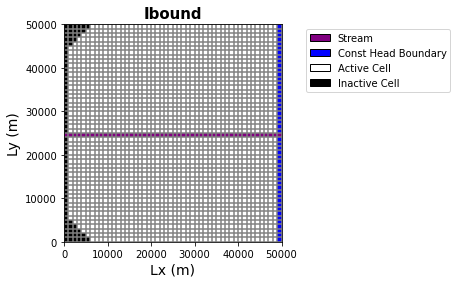

In [6]:
modelmap = flopy.plot.PlotMapView(model=m, layer=0)
grid = modelmap.plot_grid()
ib = modelmap.plot_ibound()
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.title('Ibound', fontsize = 15, fontweight = 'bold')
#wel_m = modelmap.plot_bc("WEL")
str_m = modelmap.plot_bc("STR")
plt.legend(handles=[mp.patches.Patch(color='purple',label='Stream',ec='black'),
                   mp.patches.Patch(color='blue',label='Const Head Boundary',ec='black'),
                   mp.patches.Patch(color='white',label='Active Cell',ec='black'),
                   mp.patches.Patch(color='black',label='Inactive Cell',ec='black')],
                   bbox_to_anchor=(1.8,1.0))
plt.show(modelmap)

# Write MODFLOW input files and run the model

In [7]:
m.write_input()

success, mfoutput = m.run_model(pause=False, report=True)
if not success:
    raise Exception('MODFLOW did not terminate normally.')

FloPy is using the following executable to run the model: C:/Users/dnahh/Desktop/GW_Modeling/homework-hsiehdf/Working/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.11.00 8/8/2013                        

 Using NAME file: NTNA_model.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2022/04/20 11:53:11

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2022/04/20 11:53:11
 Elapsed run time:  0.155 Seconds

  Normal termination of simulation


# Graphs for NTNA

### Attempted Contour Head Plot 

C:\Users\dnahh\miniconda3\envs\gwmod\lib\site-packages\flopy\plot\map.py:819: DeprecationWarning: plot_discharge() has been deprecated and will be replaced in version 3.3.5. Use plot_vector() instead, which should follow after postprocessing.get_specific_discharge()
  warnings.warn(
C:\Users\dnahh\miniconda3\envs\gwmod\lib\site-packages\flopy\plot\plotutil.py:1630: DeprecationWarning: centered_specific_discharge() has been deprecated and will be removed in version 3.3.5. Use postprocessing.get_specific_discharge() instead.
  warnings.warn(


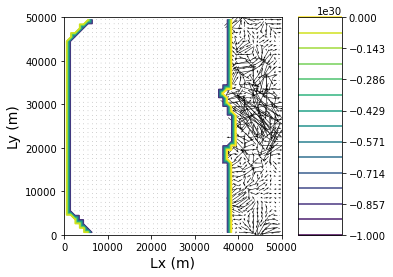

In [8]:
#####################################################################
budgobj = bf.CellBudgetFile(modelname+'.cbc')   #reads the cell budget file    
kstpkper_list = budgobj.get_kstpkper()          #returns a list of stress periods & timesteps
frf = budgobj.get_data(text='flow right face', totim=1.0) #returns an array of flow rates for right face of cells
fff = budgobj.get_data(text='flow front face', totim=1.0) #returns an array of flow rates for front face of cells     
         #string options are in the list file under output control (make sure to include spaces!)
headobj = flopy.utils.binaryfile.HeadFile(modelname+'.hds')
head = headobj.get_data(totim=1.0)

# Plotting heads and flow arrows
plt.figure() 
modelmap = flopy.plot.PlotMapView(model=m, layer=0) #use modelmap to attach plot to model
# grid = modelmap.plot_grid() #plot model grid
contour_levels = np.linspace(head[0].min(),head[0].max(),15) #set contour levels for contouring head
head_contours = modelmap.contour_array(head, levels=contour_levels) #create head contours
flows = modelmap.plot_discharge(frf[0], fff[0], head=head) #create discharge arrows
#display parameters
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
#plt.title('Steady-State Pumping, Flow(f^3/d) and Head(m) Results', fontsize = 15, fontweight = 'bold')
plt.colorbar(head_contours, aspect=5)
plt.show(modelmap)

### Attempted Head Profile

### Our domain dries

C:\Users\dnahh\AppData\Local\Temp\ipykernel_21592\1678668645.py:3: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig_3d.gca(projection='3d')


Text(0.5, 0.92, 'Steady-State Model Head Profile')

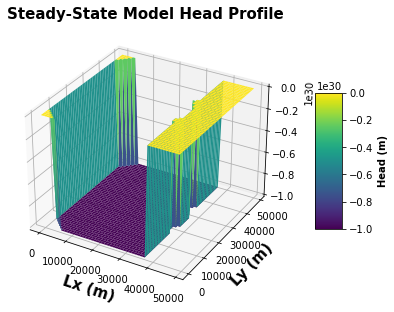

In [9]:
#create 3d figure
fig_3d = plt.figure(figsize=(12,5))
ax = fig_3d.gca(projection='3d')

#set X, Y, Z variables for 3d plot to be our model domain and head solution
X = np.arange(0,Lx,dx)
Y = np.arange(0,Ly,dy)
X, Y = np.meshgrid(X, Y)
Z = np.flipud(head[0])

#create surface and labels
surf = ax.plot_surface(X,Y,Z, cmap = 'viridis', linewidth=0, label='head')
fig_3d.colorbar(surf,shrink=0.5,aspect=5).set_label('Head (m)',fontsize=10,fontweight='bold')
ax.set_xlabel('Lx (m)', fontsize=15, fontweight='bold')
ax.set_ylabel('Ly (m)', fontsize=15, fontweight='bold')
ax.set_title('Steady-State Model Head Profile', fontsize=15, fontweight='bold')
# plt.savefig('BoxModel_Surface1.png') 
#plt.show(surf)

# Cross Section Figures NTNA

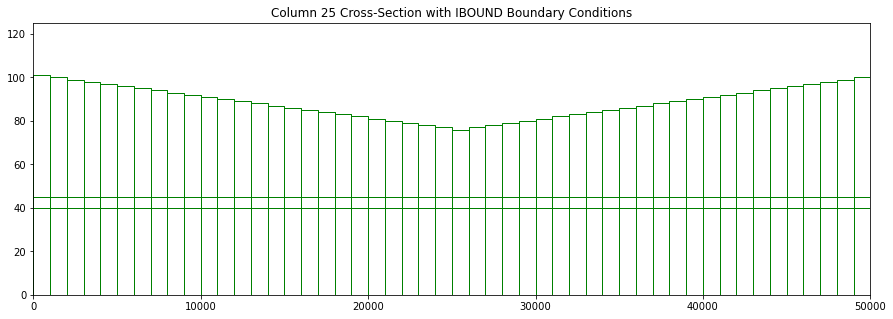

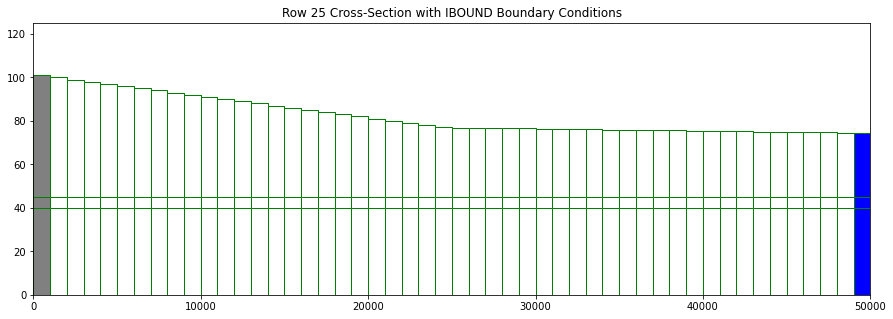

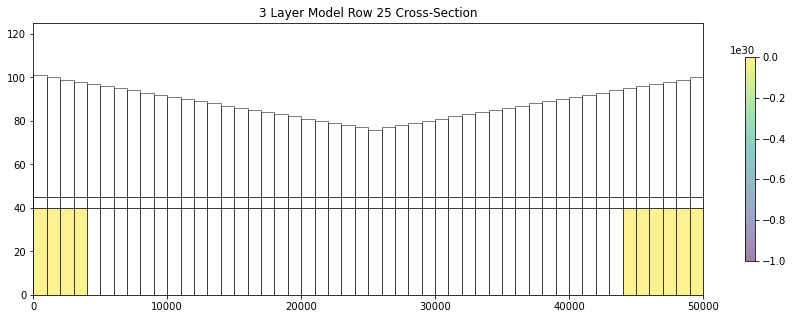

In [10]:
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 1, 1)

xsect = flopy.plot.PlotCrossSection(model=m, line={'column': 24}) #note use the key 'column' if you want to plot a column instead
patches = xsect.plot_ibound(color_noflow='red', color_ch='blue')
#patches = xsect.plot_bc('WEL', color='red')
linecollection = xsect.plot_grid(color='green')
t = ax.set_title('Column 25 Cross-Section with IBOUND Boundary Conditions')

fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 1, 1)

xsect = flopy.plot.PlotCrossSection(model=m, line={'row': 24}) #note use the key 'column' if you want to plot a column instead
patches = xsect.plot_ibound(color_noflow='gray', color_ch='blue')
#patches = xsect.plot_bc('WEL', color='red')
linecollection = xsect.plot_grid(color='green')
t = ax.set_title('Row 25 Cross-Section with IBOUND Boundary Conditions')

#### 3 layered model 
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 1, 1)

xsect = flopy.plot.PlotCrossSection(model=m, line={'column': 24}) #note use the key 'column' if you want to plot a column instaed
pc = xsect.plot_array(head, masked_values=[999.], head=head, alpha=0.5)
patches = xsect.plot_ibound(head=head)
#patches = xsect.plot_ibound(color_noflow='red', color_ch='blue')
#patches = xsect.plot_bc('WEL', color='red')
linecollection = xsect.plot_grid(color='black', lw=0.5)
t = ax.set_title('3 Layer Model Row 25 Cross-Section')
cb = plt.colorbar(pc, shrink=0.75)
#Overlay the head in a layer of the model- in this case I'm doing the top layer i.e. head3[0,:,:]
wt = xsect.plot_surface(head[0,:,:], masked_values=[999.], color='blue', lw=1)

# Yes Town No Ag - Model 2

### Setting up Packages for YTNA Scenario

In [11]:
modelname = "YTNA_model"
moddir="C:/Users/dnahh/Desktop/GW_Modeling/homework-hsiehdf/Working/mf2005" #Update this to find your modflow application
m2 = flopy.modflow.Modflow(modelname, exe_name = moddir)

#Create dis object
dis = flopy.modflow.ModflowDis(model=m2, nlay=nlay, nrow=nrow, ncol=ncol, 
                               delr=dx, delc=dy, top=ztop, botm=botm, 
                               itmuni = 4, lenuni = 2, 
                               nper=nper, steady=steady)   #Model unit meters (lenuni = 2) and days (itmuni = 4)

# Boundary and initial conditions - bas
bas = flopy.modflow.ModflowBas(m2, ibound=ibound, strt=H_init)

#Numerical solver - pcg
pcg = flopy.modflow.ModflowPcg(model=m2)

#Layer properties - lpf
lpf = flopy.modflow.ModflowLpf(m2, laytyp=uncnf, hk=Kh, 
                               vka=Kz, ss=Ss,
                               sy=Sy,storagecoefficient=True, ipakcb=53) 


#rch = flopy.modflow.mfrch.ModflowRch(model=m2, rech=rech_zone, ipakcb=53)     #create rch object

#Output control - OC 
spd = {(0, 0): ['print head', 'print budget', 'save head', 'save budget']}
oc = flopy.modflow.ModflowOc(model=m2, stress_period_data=spd, compact=True)

#Evapotranspiration
evt = flopy.modflow.mfevt.ModflowEvt(model=m2, surf=ztop, evtr=ET_zone, exdp=extinction_depth, ipakcb=53) #ipakcb makes sure it applies to water balance of all cells, default is 0, 53 is a safe integer to choose, some are taken 


### Adding Well Package

In [12]:

#Well
pumping = -1500 #m3/day  #given
well_loc = (2,21,38) #Well loc should be layer, row, column
well_1 = [i for i in well_loc] + [pumping]
print(well_1)
print("Well 1 [layer, row, column, flux]: \n", well_1)
wel_spd = {0: [well_1]} #putting the well in the bottom layer

wel = flopy.modflow.ModflowWel(model=m2, stress_period_data=wel_spd)



[2, 21, 38, -1500]
Well 1 [layer, row, column, flux]: 
 [2, 21, 38, -1500]


# Stream Package and making segments

In [13]:
#Setup the stream characteristics 
return_loc = 25
ntrib = 1

#Setup the reach locations – here the row value will be 25 for each reach and the column values will go from 0-49
nreach =  50   # river extending the width of the domain
str_rows = 25*np.ones((nreach),dtype=np.int32)  # integer array of row #s for each reach 
str_cols = np.arange(0,nreach)  # integer array of col #s for each reach 

#Setup the inflows for the reaches
Qreturn =50     # return flow from the town
reach_flow = np.zeros((nreach),dtype=np.int32)  # initially set all inflows to zero for all reaches
reach_flow[return_loc] = Qreturn # inflow to seg2 = return from town
reach_flow[return_loc+1] = -1 # inflow to seg3 = sum of all previous segs

#setup segment numbers – this is a list of segment values that goes with each reach
return_loc = 24    #specifying the column where the town return flows come in
segments = np.ones((nreach),dtype=np.int32)    # make a segment array that is nreach long and initialize all the values to 1
segments[return_loc] = 2    #Change the segment number to ‘2’ where the town recharge comes in
segments[return_loc+1:nreach] = 3    # Change the segment number to ‘3’ everywhere downstream of the the town well

#setup reach numbers – this will be the numbering of the reaches within each segment. 
# Recall that numbering starts and one and increases moving downstream
reaches = np.arange(1,nreach+1)   # create an array of reach #s counting from 1-50
reaches[return_loc] = 1    # reassign the reach number to be 1 for segment 2
reaches[return_loc+1:nreach] = np.arange(1,nreach-(return_loc+1)+1)  # reassign the reach numbers for segment 3 to start counting at 1

# Stream Elevation
ztop = np.genfromtxt('BASE_top_elev.csv', delimiter=',') # top elevation of top layer (import from csv file) (dim: nrow, ncol)
surf_elev = np.zeros((nreach))   # create array of zeros the length of the stream

# loop over the stream reaches and pull the land surface elevation for the location of each stream cell
for i in np.arange(nreach): 
      surf_elev[i] = ztop[str_rows[i],str_cols[i]]

Stop = surf_elev -1    # elevation of the top of the streambed (1 m below land surface) (m)
Sbot = Stop - sed_thick      # elevation of the bottom of the streambed (m)
stage_elev = Stop + str_stage      # elevation of the water surface in the stream (m)


#Setup the stress period dictionary
str_info = np.zeros((nreach,13)) # create array of zeros for reaches, each reach requires 13 input values

# Loop over the reaches and setup the data
for r in np.arange(nreach): 
     str_info[r,:] = [0, str_rows[r], str_cols[r], segments[r], reaches[r], reach_flow[r], stage_elev[r], k_strbott, Sbot[r], Stop[r], width,  slope, rough]
str_spd = {0: str_info} # save the stream info in a stress period dictionary


#Setup the segments dictionary
#for each segment, need an array of 10 zeros, for last segment, first two values are seg #s of upstream segments
nseg = 3
icalc = 1
seg_info = [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1]]
str_segd = {0: seg_info}  #save the stream info in a segment dictionary

# Setup the mudflow package call
strm = flopy.modflow.mfstr.ModflowStr(m2, mxacts=nreach, nss=nseg, ntrib=ntrib, ndiv=0, icalc=icalc, const=const, ipakcb=53, istcb2=53, dtype=None, stress_period_data=str_spd, segment_data=str_segd, extension='str')


m2.write_input()

success, mfoutput = m2.run_model(pause=False, report=True)
if not success:
    raise Exception('MODFLOW did not terminate normally.')

FloPy is using the following executable to run the model: C:/Users/dnahh/Desktop/GW_Modeling/homework-hsiehdf/Working/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.11.00 8/8/2013                        

 Using NAME file: YTNA_model.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2022/04/20 11:53:16

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2022/04/20 11:53:16
 Elapsed run time:  0.107 Seconds

  Normal termination of simulation


In [14]:
print(reaches)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
  1  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]


## Plan view of domain for YTNA Bottom Layer

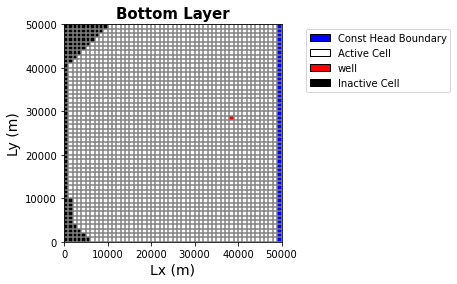

In [15]:
modelmap = flopy.plot.PlotMapView(model=m2, layer=2)
grid = modelmap.plot_grid()
ib = modelmap.plot_ibound()
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.title('Bottom Layer', fontsize = 15, fontweight = 'bold')
wel_m = modelmap.plot_bc("WEL")
#str_m = modelmap.plot_bc("STR")
plt.legend(handles=[#mp.patches.Patch(color='purple',label='Stream',ec='black'),
                   mp.patches.Patch(color='blue',label='Const Head Boundary',ec='black'),
                   mp.patches.Patch(color='white',label='Active Cell',ec='black'),
                   mp.patches.Patch(color='red',label='well',ec='black'),
                   mp.patches.Patch(color='black',label='Inactive Cell',ec='black')],
                   bbox_to_anchor=(1.8,1.0))
plt.show(modelmap)

In [16]:
budgobj1 = bf.CellBudgetFile("NTNA_model"+'.cbc')   #reads the cell budget file    

#Head - 3 layer model 
headobj3 = bf.HeadFile("YTNA_model"+'.hds')    #reads the binary head file
times = headobj3.get_times()                 #returns a list of timesteps
head3 = headobj3.get_data(totim=times[-1])   #returns a numpy array of heads for specified time (last timestep)

#Water balance - 3 layer
budgobj3 = bf.CellBudgetFile("YTNA_model"+'.cbc')   #reads the cell budget file    
print(budgobj3.get_unique_record_names())
kstpkper_list3 = budgobj1.get_kstpkper()          #returns a list of stress periods & timesteps
frf3 = budgobj3.get_data(text='flow right face', totim=1.0) #returns an array of flow rates for right face of cells
fff3 = budgobj3.get_data(text='flow front face', totim=1.0) #returns an array of flow rates for front face of cells 
recharge3 = budgobj3.get_data(text='RECHARGE', totim=1.0) 
print(len(frf3))

fig3=plt.figure(figsize=(10,10))
# print(fff1[0][0][40])
# print(frf3[0][2][40])

modelmap = flopy.plot.PlotMapView(model=m2, layer=2) #use modelmap to attach plot to model
#grid = modelmap.plot_grid() #plot model grid
qm = modelmap.plot_ibound()  
contour_levels = np.linspace(head3[0][0].min(),head3[0][0].max(),11) #set contour levels for contouring head
head_contours = modelmap.contour_array(head3, levels=contour_levels) #create head contours
flows = modelmap.plot_discharge(frf3[0], fff3[0], head=head3) #create discharge arrows

#display parameters
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.title('3 layer scenario', fontsize = 15, fontweight = 'bold')
plt.colorbar(head_contours,aspect=5)

[b'   CONSTANT HEAD', b'FLOW RIGHT FACE ', b'FLOW FRONT FACE ', b'FLOW LOWER FACE ', b'              ET', b'  STREAM LEAKAGE', b'STREAM FLOW OUT ']


Exception: The specified text string is not in the budget file.

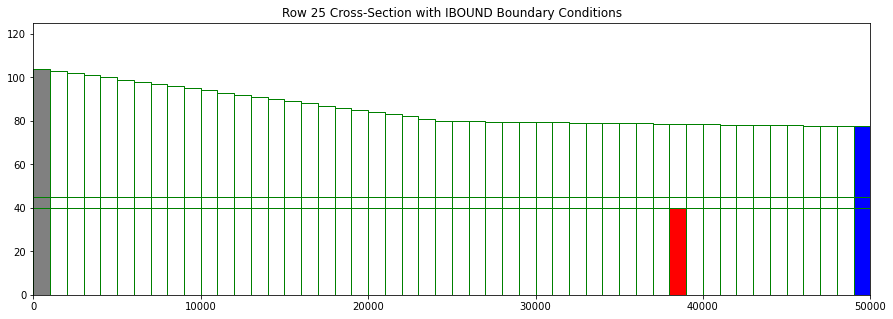

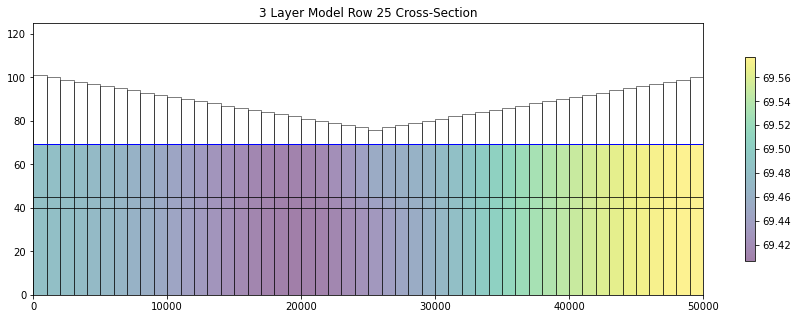

In [ ]:
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 1, 1)

xsect = flopy.plot.PlotCrossSection(model=m2, line={'row': 21}) #note use the key 'column' if you want to plot a column instead
patches = xsect.plot_ibound(color_noflow='gray', color_ch='blue')
patches = xsect.plot_bc('WEL', color='red')
linecollection = xsect.plot_grid(color='green')
t = ax.set_title('Row 25 Cross-Section with IBOUND Boundary Conditions')

#### 3 layered model 
#Head - 3 layer model 
headobj3 = bf.HeadFile("YTNA_model"+'.hds')    #reads the binary head file
times = headobj3.get_times()                 #returns a list of timesteps
head3 = headobj3.get_data(totim=times[-1])   #returns a numpy array of heads for specified time (last timestep)

fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 1, 1)

xsect = flopy.plot.PlotCrossSection(model=m2, line={'column': 24}) #note use the key 'column' if you want to plot a column instaed
pc = xsect.plot_array(head3, masked_values=[999.], head=head3, alpha=0.5)
patches = xsect.plot_ibound(head=head3)
#patches = xsect.plot_ibound(color_noflow='red', color_ch='blue')
#patches = xsect.plot_bc('WEL', color='red')
linecollection = xsect.plot_grid(color='black', lw=0.5)
t = ax.set_title('3 Layer Model Row 25 Cross-Section')
cb = plt.colorbar(pc, shrink=0.75)
#Overlay the head in a layer of the model- in this case I'm doing the top layer i.e. head3[0,:,:]
wt = xsect.plot_surface(head3[0,:,:], masked_values=[999.], color='blue', lw=1)

C:\Users\dnahh\miniconda3\envs\gwmod\lib\site-packages\flopy\plot\map.py:819: DeprecationWarning: plot_discharge() has been deprecated and will be replaced in version 3.3.5. Use plot_vector() instead, which should follow after postprocessing.get_specific_discharge()
  warnings.warn(
C:\Users\dnahh\miniconda3\envs\gwmod\lib\site-packages\flopy\plot\plotutil.py:1630: DeprecationWarning: centered_specific_discharge() has been deprecated and will be removed in version 3.3.5. Use postprocessing.get_specific_discharge() instead.
  warnings.warn(


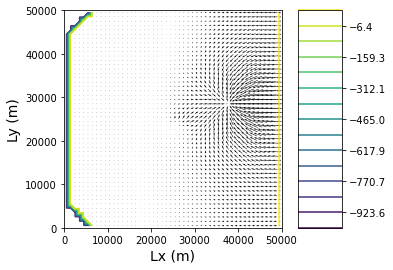

In [61]:
#####################################################################
# Reading budget and head output files
budgobj1 = bf.CellBudgetFile("YTNA_model"+'.cbc')   #reads the cell budget file    
#print(budgobj1.get_unique_record_names())
frf = budgobj1.get_data(text='flow right face', totim=1.0) #returns an array of flow rates for right face of cells
fff = budgobj1.get_data(text='flow front face', totim=1.0) #returns an array of flow rates for front face of cells 
leak = budgobj1.get_data(text='STREAM LEAKAGE', totim=1.0) 

str_outflow = budgobj1.get_data(text='STREAM FLOW OUT', totim=1.0) 
ch_flow = budgobj1.get_data(text='CONSTANT HEAD', totim=1.0) 

headobj = flopy.utils.binaryfile.HeadFile("YTNA_model"+'.hds')
head = headobj.get_data(totim=1.0)

#####################################################################
# Plotting heads and flow arrows
plt.figure() 
modelmap = flopy.plot.PlotMapView(model=m2, layer=0) #use modelmap to attach plot to model
# grid = modelmap.plot_grid() #plot model grid
contour_levels = np.linspace(head[0].min(),head[0].max(),15) #set contour levels for contouring head
head_contours = modelmap.contour_array(head, levels=contour_levels) #create head contours
flows = modelmap.plot_discharge(frf[0], fff[0], head=head) #create discharge arrows
#display parameters
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
#plt.title('Steady-State Pumping, Flow(f^3/d) and Head(m) Results', fontsize = 15, fontweight = 'bold')
plt.colorbar(head_contours, aspect=5)
plt.show(modelmap)

# Yes Town Yes Ag

In [55]:
# Gather Packages and Such for the Town and Agriculture Scenario
modelname = "YTYA_model"
m3 = flopy.modflow.Modflow(modelname, exe_name = moddir)

#Discretization - dis
# no changes because we have the base case working
dis = flopy.modflow.ModflowDis(model=m3, nlay=nlay, nrow=nrow, ncol=ncol, 
                               delr=dx, delc=dy, top=ztop, botm=botm, 
                               itmuni = 4, lenuni = 2, 
                               nper=nper, steady=steady)


# Boundary and initial conditions - bas
bas = flopy.modflow.ModflowBas(m3, ibound=ibound, strt=H_init)

#Layer properties - lpf
lpf = flopy.modflow.ModflowLpf(m3, laytyp=uncnf, hk=K_horiz, 
                               vka=K_vert, ss=Ss,
                               sy=Sy,storagecoefficient=True, ipakcb=53) 


#Recharge
rech_zone = np.zeros((nrow,ncol)) 
rech_zone[:,0:16]=recharge
recharge_farm = 0.2*6e-3
rech_zone[21:23,19:21] = recharge_farm
rch = flopy.modflow.mfrch.ModflowRch(model=m3, rech=rech_zone, ipakcb=53)  #create rch object


#ET
ET_zone = np.zeros((1,nrow,ncol))     # define an array of zeroes the size of the model grid
ET_zone[:,:,25:-1] = 1e-5  # ET only on right half of domain
ET_zone[:,22:29,:] = 5e-4  #stream ET
ET_zone[21:23,19:21] = 0 # ET on farm is 0
evt = flopy.modflow.mfevt.ModflowEvt(model=m3, surf=ztop, evtr=ET_zone, exdp=extinction_depth, ipakcb=53) 
extinction_depth = 1 #extinction depth is the depth where if our water table is below that, our ET will be ZERO #between surface and extinction depth is just a linear interpolation


evt = flopy.modflow.mfevt.ModflowEvt(model=m, surf=ztop, evtr=ET_zone, exdp=extinction_depth, ipakcb=53) #ipakcb makes sure it applies to water balance of all cells, default is 0, 53 is a safe integer to choose, some are taken 


#Output control - OC 
spd = {(0,0):['print head', 'print budget', 'save head', 'save budget']} #create a dictionary for stress period data, where key (0,0) is associated with value ['print...'] 
oc = flopy.modflow.ModflowOc(model=m3, stress_period_data=spd, compact=True)

#Numerical solver - pcg
pcg = flopy.modflow.ModflowPcg(model=m3)



# Town well
Q_in1 = -1500                       # Volumetric flux from the well in units of L3/T 
fluxes1 = [2,21,28,Q_in1]

# Ag well
Q_in2 = (1/8) * -3000
fluxes2 = [0,12,14,Q_in2]
sp_fluxes = {0: fluxes1, 0: fluxes2} 
wel = flopy.modflow.ModflowWel(model=m3, stress_period_data=sp_fluxes)

print (sp_fluxes)




{0: [0, 12, 14, -375.0]}


In [56]:
#Setup the stream characteristics 
return_loc = 25
ntrib = 1

#Setup the reach locations – here the row value will be 25 for each reach and the column values will go from 0-49
nreach =  50   # river extending the width of the domain
str_rows = 25*np.ones((nreach),dtype=np.int32)  # integer array of row #s for each reach 
str_cols = np.arange(0,nreach)  # integer array of col #s for each reach 

#Setup the inflows for the reaches
Qreturn =50     # return flow from the town
reach_flow = np.zeros((nreach),dtype=np.int32)  # initially set all inflows to zero for all reaches
reach_flow[return_loc] = Qreturn # inflow to seg2 = return from town
reach_flow[return_loc+1] = -1 # inflow to seg3 = sum of all previous segs

#setup segment numbers – this is a list of segment values that goes with each reach
return_loc = 24    #specifying the column where the town return flows come in
segments = np.ones((nreach),dtype=np.int32)    # make a segment array that is nreach long and initialize all the values to 1
segments[return_loc] = 2    #Change the segment number to ‘2’ where the town recharge comes in
segments[return_loc+1:nreach] = 3    # Change the segment number to ‘3’ everywhere downstream of the the town well

#setup reach numbers – this will be the numbering of the reaches within each segment. 
# Recall that numbering starts and one and increases moving downstream
reaches = np.arange(1,nreach+1)   # create an array of reach #s counting from 1-50
reaches[return_loc] = 1    # reassign the reach number to be 1 for segment 2
reaches[return_loc+1:nreach] = np.arange(1,nreach-(return_loc+1)+1)  # reassign the reach numbers for segment 3 to start counting at 1

# Stream Elevation
ztop = np.genfromtxt('BASE_top_elev.csv', delimiter=',') # top elevation of top layer (import from csv file) (dim: nrow, ncol)
surf_elev = np.zeros((nreach))   # create array of zeros the length of the stream

# loop over the stream reaches and pull the land surface elevation for the location of each stream cell
for i in np.arange(nreach): 
      surf_elev[i] = ztop[str_rows[i],str_cols[i]]

Stop = surf_elev -1    # elevation of the top of the streambed (1 m below land surface) (m)
Sbot = Stop - sed_thick      # elevation of the bottom of the streambed (m)
stage_elev = Stop + str_stage      # elevation of the water surface in the stream (m)


#Setup the stress period dictionary
str_info = np.zeros((nreach,13)) # create array of zeros for reaches, each reach requires 13 input values

# Loop over the reaches and setup the data
for r in np.arange(nreach): 
     str_info[r,:] = [0, str_rows[r], str_cols[r], segments[r], reaches[r], reach_flow[r], stage_elev[r], k_strbott, Sbot[r], Stop[r], width,  slope, rough]
str_spd = {0: str_info} # save the stream info in a stress period dictionary


#Setup the segments dictionary
#for each segment, need an array of 10 zeros, for last segment, first two values are seg #s of upstream segments
nseg = 3
icalc = 1
seg_info = [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1]]
str_segd = {0: seg_info}  #save the stream info in a segment dictionary

# Setup the mudflow package call
strm = flopy.modflow.mfstr.ModflowStr(m3, mxacts=nreach, nss=nseg, ntrib=ntrib, ndiv=0, icalc=icalc, const=const, ipakcb=53, istcb2=53, dtype=None, stress_period_data=str_spd, segment_data=str_segd, extension='str')



In [57]:

#write the inputs
m3.write_input()    

#Run the model 
success, mfoutput = m3.run_model(pause=False, report=True)
if not success:
    raise Exception('MODFLOW did not terminate normally.')

FloPy is using the following executable to run the model: C:/Users/dnahh/Desktop/GW_Modeling/homework-hsiehdf/Working/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.11.00 8/8/2013                        

 Using NAME file: YTYA_model.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2022/04/20 12:16:00

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2022/04/20 12:16:01
 Elapsed run time:  0.131 Seconds

  Normal termination of simulation


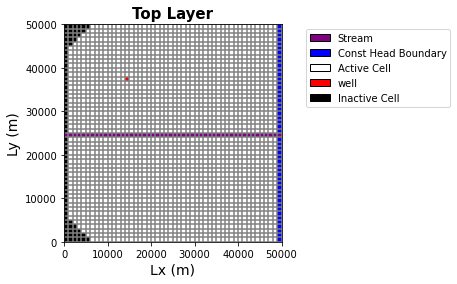

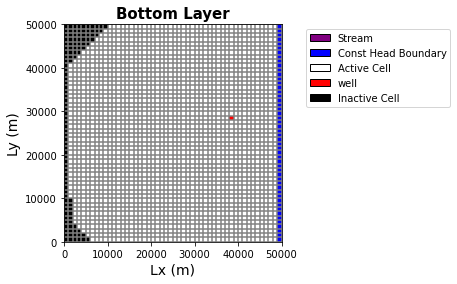

In [59]:
modelmap = flopy.plot.PlotMapView(model=m3, layer=0)
grid = modelmap.plot_grid()
ib = modelmap.plot_ibound()
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.title('Top Layer', fontsize = 15, fontweight = 'bold')
wel_m = modelmap.plot_bc("WEL")
str_m = modelmap.plot_bc("STR")
plt.legend(handles=[mp.patches.Patch(color='purple',label='Stream',ec='black'),
                   mp.patches.Patch(color='blue',label='Const Head Boundary',ec='black'),
                   mp.patches.Patch(color='white',label='Active Cell',ec='black'),
                   mp.patches.Patch(color='red',label='well',ec='black'),
                   mp.patches.Patch(color='black',label='Inactive Cell',ec='black')],
                   bbox_to_anchor=(1.8,1.0))
plt.show(modelmap)



modelmap = flopy.plot.PlotMapView(model=m2, layer=2)
grid = modelmap.plot_grid()
ib = modelmap.plot_ibound()
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.title('Bottom Layer', fontsize = 15, fontweight = 'bold')
wel_m = modelmap.plot_bc("WEL")
str_m = modelmap.plot_bc("STR")
plt.legend(handles=[mp.patches.Patch(color='purple',label='Stream',ec='black'),
                   mp.patches.Patch(color='blue',label='Const Head Boundary',ec='black'),
                   mp.patches.Patch(color='white',label='Active Cell',ec='black'),
                   mp.patches.Patch(color='red',label='well',ec='black'),
                   mp.patches.Patch(color='black',label='Inactive Cell',ec='black')],
                   bbox_to_anchor=(1.8,1.0))
plt.show(modelmap)

C:\Users\dnahh\miniconda3\envs\gwmod\lib\site-packages\flopy\plot\map.py:819: DeprecationWarning: plot_discharge() has been deprecated and will be replaced in version 3.3.5. Use plot_vector() instead, which should follow after postprocessing.get_specific_discharge()
  warnings.warn(
C:\Users\dnahh\miniconda3\envs\gwmod\lib\site-packages\flopy\plot\plotutil.py:1630: DeprecationWarning: centered_specific_discharge() has been deprecated and will be removed in version 3.3.5. Use postprocessing.get_specific_discharge() instead.
  warnings.warn(


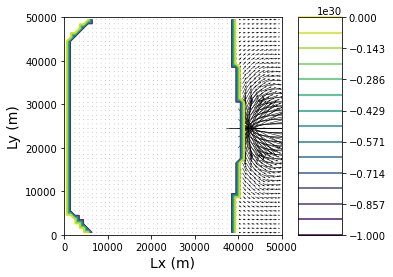

In [60]:
#####################################################################

# Reading budget and head output files
budgobj1 = bf.CellBudgetFile("YTYA_model"+'.cbc')   #reads the cell budget file    
#print(budgobj1.get_unique_record_names())
frf = budgobj1.get_data(text='flow right face', totim=1.0) #returns an array of flow rates for right face of cells
fff = budgobj1.get_data(text='flow front face', totim=1.0) #returns an array of flow rates for front face of cells 
leak = budgobj1.get_data(text='STREAM LEAKAGE', totim=1.0) 

str_outflow = budgobj1.get_data(text='STREAM FLOW OUT', totim=1.0) 
ch_flow = budgobj1.get_data(text='CONSTANT HEAD', totim=1.0) 

headobj = flopy.utils.binaryfile.HeadFile("YTYA_model"+'.hds')
head = headobj.get_data(totim=1.0)

# Plotting heads and flow arrows
plt.figure() 
modelmap = flopy.plot.PlotMapView(model=m3, layer=0) #use modelmap to attach plot to model
# grid = modelmap.plot_grid() #plot model grid
contour_levels = np.linspace(head[0].min(),head[0].max(),15) #set contour levels for contouring head
head_contours = modelmap.contour_array(head, levels=contour_levels) #create head contours
flows = modelmap.plot_discharge(frf[0], fff[0], head=head) #create discharge arrows
#display parameters
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
#plt.title('Steady-State Pumping, Flow(f^3/d) and Head(m) Results', fontsize = 15, fontweight = 'bold')
plt.colorbar(head_contours, aspect=5)
plt.show(modelmap)